<a href="https://colab.research.google.com/github/Shape95/DACON-predict_population_income/blob/main/%EC%9D%B8%EA%B5%AC_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EA%B8%B0%EB%B0%98_%EC%86%8C%EB%93%9D_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인구 데이터 기반 소득 예측 경진대회

이번 대회는 인구 데이터 바탕으로 소득이 5만달러 이하인지 초과인지 분류하는 대회입니다.

간단한 모델을 작성해서 성능을 확인하고, 성능을 개선하기 위해서는 어떻게 접근해야 하는지 생각해봅시다!

그럼 시작해볼까요?

## 데이터 불러오기 및 모듈 임포트


In [ ]:
# 기본 데이터 정리 및 처리
import pandas as pd
import numpy as np

# 시각화
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection


# 경고 제거 (판다스가 에러 메시지를 자주 만들어 내기 때문)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
import pandas as pd

dir = 'data/'

# csv 형식으로 된 데이터 파일을 읽어옵니다.
train = pd.read_csv(dir+'train.csv')
test = pd.read_csv(dir + 'test.csv')

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train['target'].values
id = test['id']

In [ ]:
data = pd.concat((train, test))
temp = data.copy()

## 파일 병합

In [ ]:
data.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1.0
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0.0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.0


<AxesSubplot:>

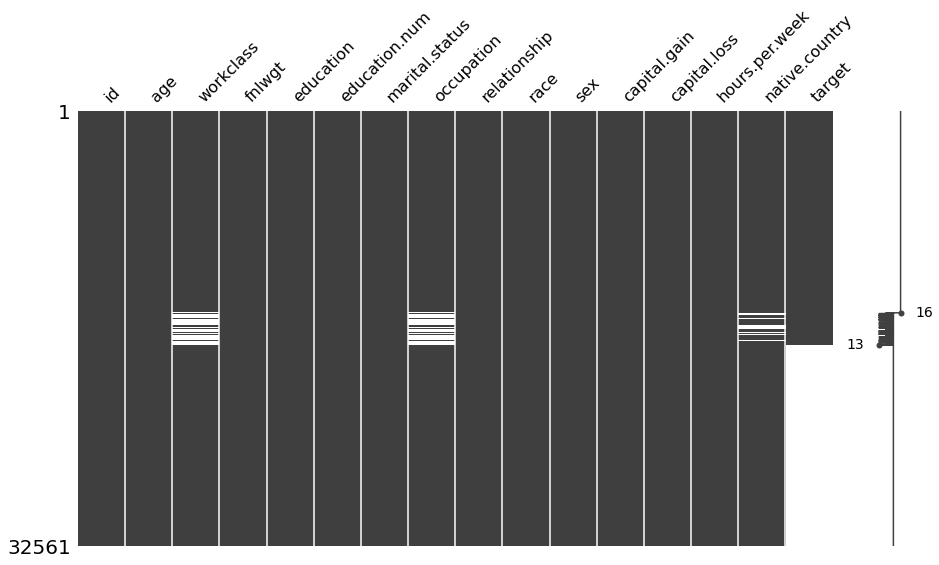

In [ ]:
missingno.matrix(data, figsize=(15,8))

In [ ]:
train.isnull().sum()

id                   0
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

### 결측치 제거

In [ ]:
train = train.dropna(axis=0)

data = pd.concat((train,test))
data.isnull().sum()

id                    0
age                   0
workclass             0
fnlwgt                0
education             0
education.num         0
marital.status        0
occupation            0
relationship          0
race                  0
sex                   0
capital.gain          0
capital.loss          0
hours.per.week        0
native.country        0
target            15081
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 15080
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education.num   15081 non-null  int64 
 6   marital.status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital.gain    15081 non-null  int64 
 12  capital.loss    15081 non-null  int64 
 13  hours.per.week  15081 non-null  int64 
 14  native.country  15081 non-null  object
 15  target          15081 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.0+ MB



## 데이터 탐구 (Exploratory Data Analysis)

info() 메소드를 이용하여 데이터의 타입을 보면 상당히 많은 데이터가 범주형인 것을 확인 할 수 있습니다.


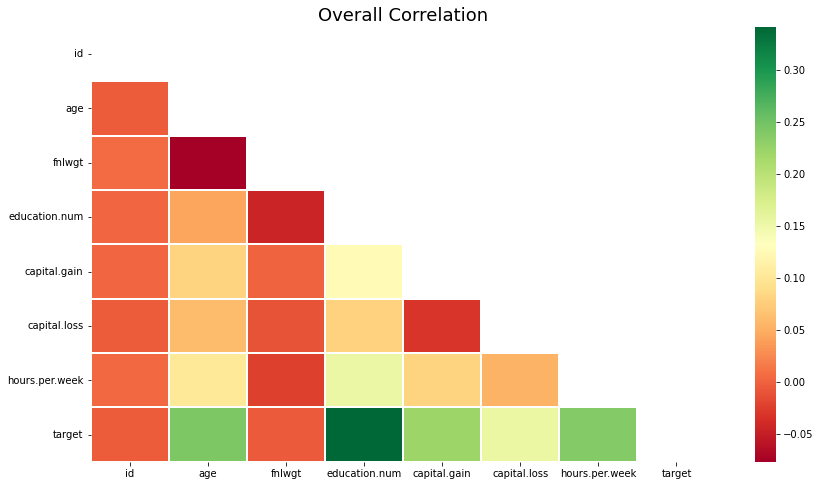

In [ ]:
# Co-relation 매트릭스
corr = data.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

### 그룹별 평균

In [ ]:
def survpct(col):
    return temp.groupby(col)['target'].mean()

### 분석용 막대그래프

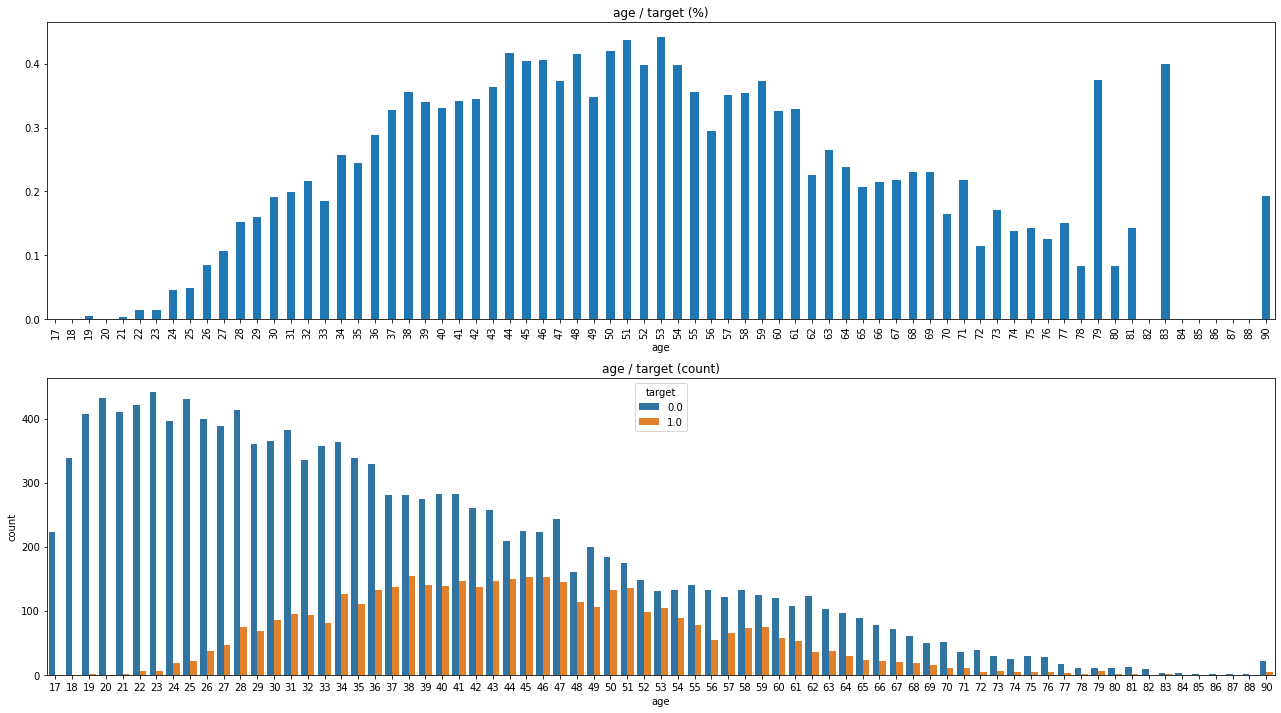

In [ ]:
def bag(col, target, title, title1):
    f,ax=plt.subplots(2,1,figsize=(22,12))
    temp.groupby([col])[target].mean().plot(kind='bar', ax=ax[0])
    ax[0].set_title(title)
    sns.countplot(col, hue=target, data=temp, ax=ax[1])
    ax[1].set_title(title1)
    plt.show()

bag('age','target','age / target (%)','age / target (count)')

### Age 분석

In [ ]:
print('Oldest Person was', data['age'].max(), 'Years')
print('Youngest Person was', data['age'].min(), 'Years')
print('Average Age was', int(data['age'].mean()), 'Years')

Oldest Person was 90 Years
Youngest Person was 17 Years
Average Age was 38 Years


In [ ]:
survpct('age')

age
17    0.000000
18    0.000000
19    0.004890
20    0.000000
21    0.002427
        ...   
85    0.000000
86    0.000000
87    0.000000
88    0.000000
90    0.192308
Name: target, Length: 73, dtype: float64

In [ ]:
temp['age_range'] = pd.qcut(train['age'], 10)

In [ ]:
survpct('age_range')

age_range
(16.999, 22.0]    0.004271
(22.0, 26.0]      0.051560
(26.0, 30.0]      0.160770
(30.0, 33.0]      0.209586
(33.0, 37.0]      0.286930
(37.0, 41.0]      0.350575
(41.0, 45.0]      0.392405
(45.0, 50.0]      0.397403
(50.0, 57.0]      0.399723
(57.0, 90.0]      0.282979
Name: target, dtype: float64

In [ ]:
temp['Agroup'] = 0

temp.loc[temp['age'] < 19.0, 'Agroup'] = 18
temp.loc[(temp['age'] >=19.0) & (temp['age'] <= 24.0), 'Agroup'] = 22
temp.loc[(temp['age'] > 24.0) & (temp['age'] < 28.0), 'Agroup'] = 26
temp.loc[(temp['age'] >= 28.0) & (temp['age'] < 32.0), 'Agroup'] = 30
temp.loc[(temp['age'] >= 32.0) & (temp['age'] < 36.0), 'Agroup'] = 34
temp.loc[(temp['age'] >= 36.0) & (temp['age'] <=  40.0), 'Agroup'] = 38
temp.loc[(temp['age'] > 40.0) & (temp['age'] <= 42.0), 'Agroup'] = 41
temp.loc[(temp['age'] > 42.0) & (temp['age'] <= 44.0), 'Agroup'] = 43
temp.loc[(temp['age'] > 44.0) & (temp['age'] <= 46.0), 'Agroup'] = 45
temp.loc[(temp['age'] > 46.0) & (temp['age'] <= 48.0), 'Agroup'] = 47
temp.loc[(temp['age'] > 48.0) & (temp['age'] <= 50.0), 'Agroup'] = 49
temp.loc[(temp['age'] > 50.0) & (temp['age'] <= 53.0), 'Agroup'] = 51
temp.loc[(temp['age'] > 53.0) & (temp['age'] <= 58.0), 'Agroup'] = 55
temp.loc[(temp['age'] > 58.0) & (temp['age'] <= 75.0), 'Agroup'] = 66
temp.loc[temp['age'] > 75.0, 'Agroup'] = 78

In [ ]:
temp.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target,age_range,Agroup
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0,"(30.0, 33.0]",34
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1.0,"(30.0, 33.0]",34
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0,"(45.0, 50.0]",45
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0.0,"(22.0, 26.0]",22
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.0,"(50.0, 57.0]",55


### workclass 분석

In [ ]:
temp['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

### fnlwgt *분석*

In [ ]:
print('Highest fnlwgt was:', temp['fnlwgt'].max())
print('Lowest fnlwgt was:', temp['fnlwgt'].min())
print('Average fnlwgt was:', temp['fnlwgt'].mean())

Highest fnlwgt was: 1484705
Lowest fnlwgt was: 12285
Average fnlwgt was: 189778.36651208502


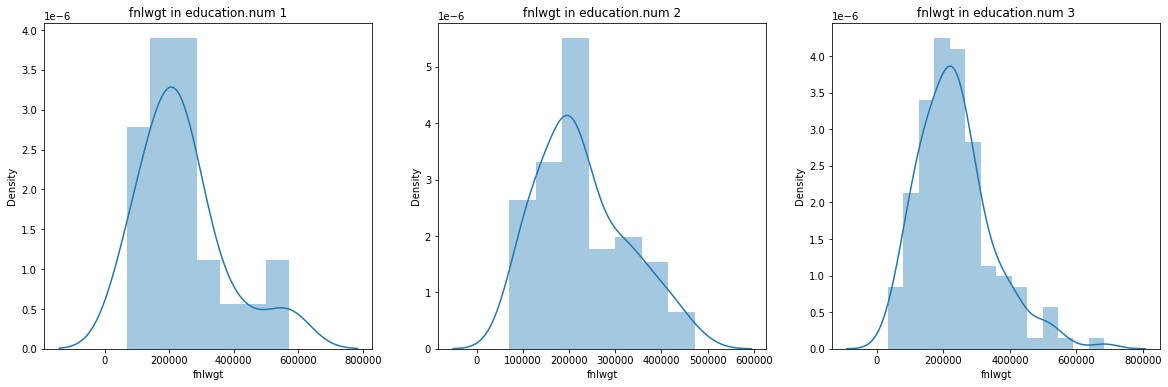

In [ ]:
f,ax=plt.subplots(1, 3, figsize=(20, 6))
sns.distplot(train[train['education.num'] == 1].fnlwgt,ax=ax[0])
ax[0].set_title('fnlwgt in education.num 1')
sns.distplot(train[train['education.num'] == 2].fnlwgt,ax=ax[1])
ax[1].set_title('fnlwgt in education.num 2')
sns.distplot(train[train['education.num'] == 3].fnlwgt,ax=ax[2])
ax[2].set_title('fnlwgt in education.num 3')
plt.show()

In [ ]:
survpct('fnlwgt')

fnlwgt
12285      0.0
13769      NaN
14878      NaN
18827      0.0
19214      0.0
          ... 
1226583    1.0
1268339    NaN
1366120    0.0
1455435    0.0
1484705    NaN
Name: target, Length: 21648, dtype: float64

In [ ]:
temp['fnlwgt_Range'] = pd.qcut(train['fnlwgt'], 10)

In [ ]:
def groupmean(a,b):
    return temp.groupby([a])[b].mean().to_frame().style.background_gradient(cmap='summer_r')

groupmean('fnlwgt_Range', 'fnlwgt')

,fnlwgt
fnlwgt_Range,
"(18826.999, 66434.0]",116798.029821
"(66434.0, 106183.0]",137554.011936
"(106183.0, 131310.0]",153209.250332
"(131310.0, 158800.0]",165314.276194
"(158800.0, 178251.0]",179994.473806
"(178251.0, 195994.0]",192642.000000
"(195994.0, 220066.0]",198270.209881
"(220066.0, 261497.0]",215881.800729
"(261497.0, 328051.0]",240022.269231


In [ ]:
temp['Fgroup'] = 0

temp.loc[temp['fnlwgt'] <= 18826,'Fgroup'] = 18826
temp.loc[(temp['fnlwgt'] > 18826) & (temp['fnlwgt'] <= 42630), 'Fgroup'] = 1
temp.loc[(temp['fnlwgt'] > 42630) & (temp['fnlwgt'] <= 86308), 'Fgroup'] = 2
temp.loc[(temp['fnlwgt'] > 86308) & (temp['fnlwgt'] <= 118746), 'Fgroup'] = 3
temp.loc[(temp['fnlwgt'] > 118746) & (temp['fnlwgt'] < 145055), 'Fgroup'] = 4
temp.loc[(temp['fnlwgt'] >= 145055) & (temp['fnlwgt'] < 168525), 'Fgroup'] = 5
temp.loc[(temp['fnlwgt'] >= 168525) & (temp['fnlwgt'] <= 187122), 'Fgroup'] = 6
temp.loc[(temp['fnlwgt'] > 187122) & (temp['fnlwgt'] <= 208030), 'Fgroup'] = 7
temp.loc[(temp['fnlwgt'] > 208030) & (temp['fnlwgt'] <= 240781), 'Fgroup'] = 8
temp.loc[temp['fnlwgt'] > 240781, 'Fgroup'] = 9

temp.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target,age_range,Agroup,fnlwgt_Range,Fgroup
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0,"(30.0, 33.0]",34,"(261497.0, 328051.0]",9
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1.0,"(30.0, 33.0]",34,"(195994.0, 220066.0]",7
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0.0,"(45.0, 50.0]",45,"(131310.0, 158800.0]",5
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0.0,"(22.0, 26.0]",22,"(178251.0, 195994.0]",7
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0.0,"(50.0, 57.0]",55,"(18826.999, 66434.0]",2


### education 분석

In [ ]:
temp['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

### education.num 분석

In [ ]:
survpct(temp['education.num'])

education.num
1     0.000000
2     0.031250
3     0.045685
4     0.060847
5     0.047619
6     0.058824
7     0.045181
8     0.056225
9     0.151635
10    0.189501
11    0.262431
12    0.251701
13    0.414145
14    0.552660
15    0.720930
16    0.738318
Name: target, dtype: float64

### marital.status 분석

In [ ]:
temp['marital.status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

### marital.status 분석

### capital.gain 분석

In [ ]:
survpct(temp['capital.gain'])

capital.gain
0        0.201534
114      0.000000
401      0.000000
594      0.000000
914      0.000000
           ...   
25236    1.000000
27828    1.000000
34095    0.000000
41310    0.000000
99999    1.000000
Name: target, Length: 119, dtype: float64

In [ ]:
temp['capital_gain'] = temp['capital.gain']

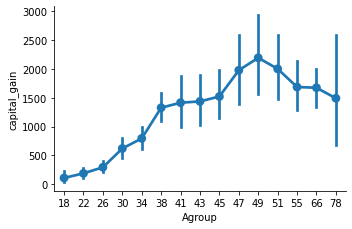

In [ ]:
sns.factorplot('Agroup', 'capital_gain', data=temp)
fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.show()

In [ ]:
temp['capital_gain'].value_counts()

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
5060         1
4931         1
22040        1
2387         1
1455         1
Name: capital_gain, Length: 119, dtype: int64

#### capital_gain은 0인 값이 많기 때문에 skip합니다.

In [ ]:
temp.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,...,capital.gain,capital.loss,hours.per.week,native.country,target,age_range,Agroup,fnlwgt_Range,Fgroup,capital_gain
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,...,0,0,40,United-States,0.0,"(30.0, 33.0]",34,"(261497.0, 328051.0]",9,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,...,0,0,40,United-States,1.0,"(30.0, 33.0]",34,"(195994.0, 220066.0]",7,0
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,...,0,0,40,United-States,0.0,"(45.0, 50.0]",45,"(131310.0, 158800.0]",5,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,...,0,0,30,United-States,0.0,"(22.0, 26.0]",22,"(178251.0, 195994.0]",7,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,...,0,0,40,United-States,0.0,"(50.0, 57.0]",55,"(18826.999, 66434.0]",2,0


### hours.per.week 분석

In [ ]:
survpct(temp['hours.per.week'])
temp['HPWgroup'] = pd.cut(temp['hours.per.week'], 10)

In [ ]:
temp['HPWgroup'].value_counts()

(30.4, 40.2]     17735
(40.2, 50.0]      5938
(20.6, 30.4]      2317
(10.8, 20.6]      2192
(59.8, 69.6]      1796
(50.0, 59.8]      1058
(0.902, 10.8]      736
(69.6, 79.4]       448
(79.4, 89.2]       202
(89.2, 99.0]       139
Name: HPWgroup, dtype: int64

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 15080
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              32561 non-null  int64   
 1   age             32561 non-null  int64   
 2   workclass       30725 non-null  object  
 3   fnlwgt          32561 non-null  int64   
 4   education       32561 non-null  object  
 5   education.num   32561 non-null  int64   
 6   marital.status  32561 non-null  object  
 7   occupation      30718 non-null  object  
 8   relationship    32561 non-null  object  
 9   race            32561 non-null  object  
 10  sex             32561 non-null  object  
 11  capital.gain    32561 non-null  int64   
 12  capital.loss    32561 non-null  int64   
 13  hours.per.week  32561 non-null  int64   
 14  native.country  31978 non-null  object  
 15  target          17480 non-null  float64 
 16  age_range       30162 non-null  category
 17  Agroup      

## 학습 Feature 항목 결정


In [ ]:
temp['F1'] = temp['Agroup']
temp['F2'] = temp['Fgroup']
temp['F3'] = temp['workclass']
temp['F4'] = temp['education']
temp['F5'] = temp['education.num']
temp['F6'] = temp['marital.status']
temp['F7'] = temp['occupation']
temp['F8'] = temp['relationship']
temp['F9'] = temp['race']
temp['F10'] = temp['sex']
temp['F11'] = temp['native.country']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### Label 인코딩

In [ ]:
dfl = pd.DataFrame() # for label encoding

good_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11']
dfl[good_columns] = temp[good_columns]

In [ ]:
dfl.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
0,34,9,Private,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,34,7,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,45,5,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
3,22,7,Private,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,United-States
4,55,2,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,United-States


### One-Hot 인코딩

In [ ]:
dfh = dfl.copy()

In [ ]:
dfl_enc = dfl.apply(LabelEncoder().fit_transform)
                          
dfl_enc.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
0,4,8,3,7,11,2,2,0,4,1,38
1,4,6,3,15,9,2,3,0,4,1,38
2,8,4,3,15,9,2,2,0,4,1,38
3,1,6,3,9,12,4,0,3,4,0,38
4,12,1,3,11,8,0,0,1,4,0,38


In [ ]:
one_hot_cols = dfh.columns.tolist()
dfh_enc = pd.get_dummies(dfh, columns=one_hot_cols)

dfh_enc.head()

,F1_18,F1_22,F1_26,F1_30,F1_34,F1_38,F1_41,F1_43,F1_45,F1_47,...,F11_Portugal,F11_Puerto-Rico,F11_Scotland,F11_South,F11_Taiwan,F11_Thailand,F11_Trinadad&Tobago,F11_United-States,F11_Vietnam,F11_Yugoslavia
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 머신러닝 모델

In [ ]:
train = dfh_enc[:ntrain]
test = dfh_enc[ntrain:]

In [ ]:
X_test = test
X_train = train

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores = {}

# 이어서 연속적으로 모델을 학습 시키고 교차 검증합니다.
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    scores[model_names[ind]] = acc

In [ ]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)

,0,1,2,3,4,mean
Logistic Regression,0.840389,0.843249,0.830092,0.836670,0.843249,0.838730
AdaBoost,0.837529,0.836957,0.831522,0.833238,0.842963,0.836442
SVC,0.837243,0.837529,0.829805,0.834096,0.834382,0.834611
Gradient Boosting,0.836098,0.833524,0.832666,0.830950,0.835526,0.833753
XGBoost,0.828661,0.832380,0.826087,0.834668,0.840103,0.832380
Random Forest,0.826945,0.823513,0.816648,0.820080,0.834096,0.824256
Extra Trees,0.813787,0.815503,0.810927,0.816076,0.831236,0.817506
K Nearest Neighbour,0.807494,0.812929,0.802059,0.807494,0.816076,0.809211
Bagging Classifier,0.804920,0.809211,0.798627,0.810641,0.821796,0.809039
Gaussian Process,0.784897,0.774600,0.773741,0.778890,0.797483,0.781922


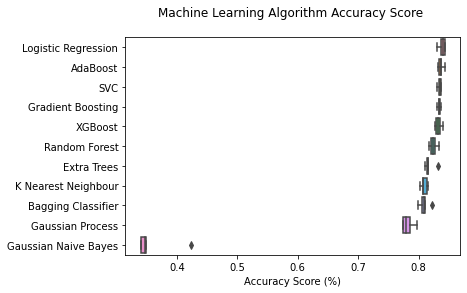

In [ ]:
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [ ]:
# 중요도를 보는 함수를 만듭니다.
def importance_plotting(data, xlabel, ylabel, title, n=20):
    sns.set(style="whitegrid")
    ax = data.tail(n).plot(kind='barh')
    
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    plt.show()

In [ ]:
# 데이터 프레임에 항목 중요도를 넣습니다.
fi = {'Features':train.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

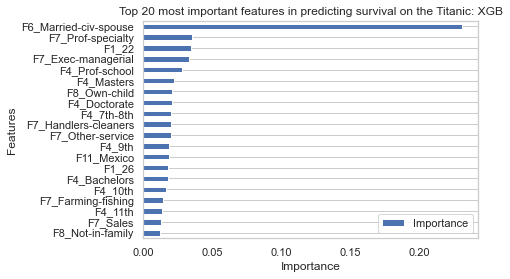

In [ ]:
# 그래프 제목
title = 'Top 20 most important features: XGB'

# 그래프 그리기
importance_plotting(importance, 'Importance', 'Features', title, 20)

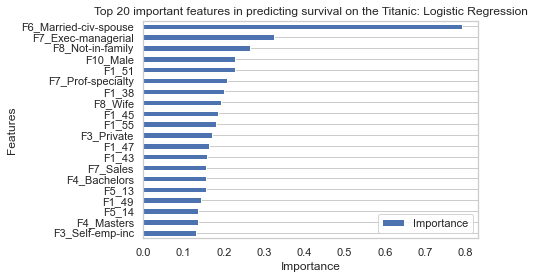

In [ ]:
# 중요도를 데이터프레임에 넣습니다. Logistic regression에서는 중요도보다 coefficients를 사용합니다. 
# 아래는 Features라는 열에 트레인의 열들의 이름을 리스트로 만들어서 넣고 Importance에는 Logistic regression에는 coefficient를 바꾸어 넣어라는 넘파이 명령입니다.(즉 가로를 세로로)
fi = {'Features':train.columns.tolist(), 'Importance':np.transpose(log.coef_[0])}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)
# 그래프 타이틀
title = 'Top 20 important features : Logistic Regression'

# 그래프 그리기
importance_plotting(importance, 'Importance', 'Features', title, 20)

In [ ]:
# 5가지 모델에 대한 항목 중요도 얻기
gbc_imp = pd.DataFrame({'Feature':train.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':train.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':train.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':train.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':train.columns, 'ada importance':ada.feature_importances_})

# 이를 하나의 데이터프레임으로
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# 항목당 평균 중요도
importances['Average'] = importances.mean(axis=1)

# 랭킹 정하기
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

In [ ]:
# 파라미터 서치
Cs = [0.01, 0.1, 1, 5, 10, 15, 20, 50]
gammas = [0.001, 0.01, 0.1]

# 파라미터 그리드 셋팅
hyperparams = {'C': Cs, 'gamma' : gammas}

# 교차검증
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

# 모델 fiting 및 결과
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.8348398169336384
{'C': 10, 'gamma': 0.001}


In [ ]:
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators = [100, 1000, 2000]
max_depth = [3, 5, 10, 15]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.8391304347826087
{'learning_rate': 0.05, 'n_estimators': 1000}


In [ ]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8387299771167047
{'C': 1.0, 'penalty': 'l2'}


In [ ]:
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 50, 100, 250, 500, 1000]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.8379290617848969
{'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.8334668192219681
{'max_depth': 9, 'min_child_weight': 6}


In [ ]:
gamma = [i*0.1 for i in range(0,5)]

hyperparams = {'gamma': gamma}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8295766590389017
{'gamma': 0.4}


In [ ]:
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.8314645308924484
{'colsample_bytree': 0.75, 'subsample': 1}


In [ ]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
    
hyperparams = {'reg_alpha': reg_alpha}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=6, 
                                          min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1),
                                         param_grid = hyperparams, verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8307780320366133
{'reg_alpha': 1}


In [ ]:
n_estimators = [10, 50, 100, 200]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.8371281464530892
{'max_depth': None, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
0.8352402745995423
{'max_depth': None, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 75}


In [ ]:
n_neighbors = [1, 2, 3, 4, 5]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]

hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.8092105263157896
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5, 'weights': 'uniform'}


In [ ]:
n_estimators = [10, 50, 75, 100, 200]
max_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
max_features = [0.1, 0.2, 0.5, 0.8, 1.0]

hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
0.8362128146453088
{'max_features': 0.8, 'max_samples': 0.1, 'n_estimators': 200}


In [ ]:
ran = RandomForestClassifier(max_depth= None, max_features= 0.1, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 100, random_state=1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=5, weights='uniform')

log = LogisticRegression(C=1.0, penalty='l2')

xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=9, 
                                          min_child_weight=6, gamma=0.4, subsample=1, colsample_bytree=0.75, reg_alpha=1)

gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=1000)

svc = SVC(probability=True, gamma=0.001, C=10)

ext = ExtraTreesClassifier(max_depth=None, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=75, random_state=1)

ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=1)

gpc = GaussianProcessClassifier(max_iter_predict=1, n_restarts_optimizer=0, warm_start=True)

bag = BaggingClassifier(max_features=0.8, max_samples=0.1, n_estimators=200, random_state=1)

In [ ]:
scores3={}
knn.fit(X_train, y_train)
acc = cross_val_score(knn, X_train, y_train, scoring = 'accuracy', cv=10)
scores3['K Nearest Neighbour'] = acc

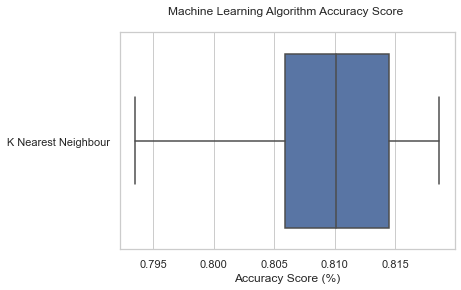

In [ ]:
results = pd.DataFrame(scores3).T
results['mean'] = results.mean(1)
result_df = results.sort_values(by='mean', ascending=False)
result_df.head(11)

result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [ ]:
scores4 = {}

# 이어서 연속적으로 모델을 학습 시키고 교차 검증합니다.
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    scores4[model_names[ind]] = acc

In [ ]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores4).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)

,0,1,2,3,4,mean
Logistic Regression,0.840389,0.843249,0.830092,0.836670,0.843249,0.838730
AdaBoost,0.837529,0.836957,0.831522,0.833238,0.842963,0.836442
SVC,0.837243,0.837529,0.829805,0.834096,0.834382,0.834611
Gradient Boosting,0.836098,0.833524,0.832666,0.830950,0.835526,0.833753
XGBoost,0.828661,0.832380,0.826087,0.834668,0.840103,0.832380
Random Forest,0.826945,0.823513,0.816648,0.820080,0.834096,0.824256
Extra Trees,0.812929,0.817506,0.810069,0.817220,0.828947,0.817334
Bagging Classifier,0.804062,0.813215,0.807780,0.809211,0.826945,0.812243
K Nearest Neighbour,0.807494,0.812929,0.802059,0.807494,0.816076,0.809211
Gaussian Process,0.784897,0.774600,0.773741,0.778890,0.797483,0.781922


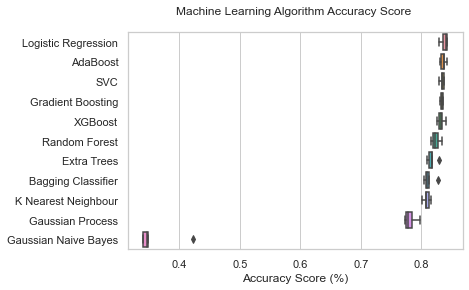

In [ ]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores4).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [ ]:
#튜닝한 파라미터로 하드보팅
grid_hard = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'hard')

grid_hard_cv = model_selection.cross_validate(grid_hard, X_train, y_train, cv=10)
grid_hard.fit(X_train, y_train)

print("Hard voting on test set score mean: {:.2f}". format(grid_hard_cv['test_score'].mean() * 100))

Hard voting on test set score mean: 83.67


In [ ]:
grid_soft = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv=10)
grid_soft.fit(X_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean() * 100))

Soft voting on test set score mean: 83.60


In [ ]:
test.head()
test1 = pd.read_csv(dir + 'test.csv')

In [ ]:

# Final predictions2
predictions = grid_hard.predict(X_test)

submission = pd.concat([pd.DataFrame(test1['id']), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["id", "target"]
submission.to_csv('data/submission1.csv', header = True, index = False)

In [ ]:
# Final predictions
predictions = grid_soft.predict(X_test)

submission = pd.concat([pd.DataFrame(test1['id']), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["id", "target"]
submission.to_csv('data/submission2.csv', header = True, index = False)

In [ ]:
from sklearn.linear_model import LogisticRegression

# 모델 선언
model = LogisticRegression(solver='liblinear')

# 모델 학습
model.fit(X, y)

## 하이퍼 파라미터 튜닝


In [ ]:
# 먼저 점수를 메기는 방법인 평가 지표(Metric)를 정의합니다.
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
# 모델의 예측과 실제 정답값을 비교합니다.
prediction = model.predict(X)

score = ACCURACY(y, prediction)

print(f"모델의 정확도는 {score*100:.2f}% 입니다")

## 추론 (Inference)

In [ ]:
# csv형식으로 된 데이터 파일을 읽어옵니다.
test.head()

마찬가지로 테스트 셋에서도 똑같이 전처리를 해줍니다.

In [ ]:
test = label_encoder(test, make_label_map(test))
test = test.drop(['id'],axis=1)
test.head()

In [ ]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = model.predict(test)
prediction

## Dacon 대회에 제출하기 (Submission)

이제 학습한 모델을 사용하여 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [ ]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv(dir+'sample_submission.csv')
submission.head()

In [ ]:
submission['target'] = prediction

# 데이터가 잘 들어갔는지 확인합니다
submission

submission을 csv 파일로 저장합니다.   
index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다.    
정확한 채점을 위해 꼭 index=False를 넣어주세요.

In [ ]:
submission.to_csv(dir+'submit.csv', index=False)

이렇게 생성된 submission.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인해보세요!

문제를 해결하기 위한 여러분의 방법을 코드 공유 게시판에 공유해주세요

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!